In [137]:
#Library Imports 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import requests
import json 
from datetime import timezone,datetime,timedelta
from dateutil.tz import tzlocal

In [138]:
# NVD's CVE API documentation: https://csrc.nist.gov/CSRC/media/Projects/National-Vulnerability-Database
# /documents/web%20service%20documentation/Automation%20Support%20for%20CVE%20Retrieval.pdf
# TODOs:  Issue with hardcoding "%20UTC-00:00"? 
def queryRecentCves(num_results: int) -> str:
    base_cve_api = 'https://services.nvd.nist.gov/rest/json/cves/1.0'
    yesterday = datetime.now() - timedelta(1)
    y_mid = yesterday.replace(hour=0, minute=0, second=0, microsecond=0).strftime('%Y-%m-%dT%H:%M:%S:%f')
    y = y_mid[:-3]
    query = base_cve_api + '?resultsPerPage=' + str(num_results) + '&pubStartDate=' + y + "%20UTC-00:00"
    #Verify desired URL to verify 
    print(query)
    r = requests.get(url=query)
    json_data = r.json()
    return json_data 


#Function Call
json_data = queryRecentCves(100)

https://services.nvd.nist.gov/rest/json/cves/1.0?resultsPerPage=100&pubStartDate=2021-08-05T00:00:00:000%20UTC-00:00


In [139]:
# NOTE: If using a json file instead of using an http request
# Modify function json_to_df: remove ['result'] from all lines that include: 
# data['result']['CVE_Items'][i]['cve']['CVE_data_meta']['ID']
# f = open('recent.json',)
# json_data = json.load(f)
# Function Call: cve_data = json_to_df(json_data)
def json_to_df(data) -> pd.core.frame.DataFrame:
    cve_dict = data['result']['CVE_Items']
    cve_num = len(cve_dict)
    all_cves = []
    for i in range(cve_num): 
        new_row = []
        CVE = data['result']['CVE_Items'][i]['cve']['CVE_data_meta']['ID']
        new_row.append(CVE)
        date = data['result']['CVE_Items'][i]['publishedDate']
        new_row.append(date)
        cwe = data['result']['CVE_Items'][i]['cve']['problemtype']['problemtype_data'][0]['description']
        if cwe == []:
            new_row.append(0)
        elif cwe != []:
            cwe = data['result']['CVE_Items'][i]['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            new_row.append(cwe)
        impact =  data['result']['CVE_Items'][i]['impact']
        if impact == {}:
            new_row.append(0)
            new_row.append(0)
            new_row.append(0)
            new_row.append(0)
            new_row.append(0)
        elif impact != {}:
            exploit_score = data['result']['CVE_Items'][i]['impact']['baseMetricV3']['exploitabilityScore']
            new_row.append(exploit_score)
            impact_score = data['result']['CVE_Items'][i]['impact']['baseMetricV3']['impactScore']
            new_row.append(impact_score)
            vstring = data['result']['CVE_Items'][i]['impact']['baseMetricV3']['cvssV3']['vectorString']
            new_row.append(vstring)
            base_score = data['result']['CVE_Items'][i]['impact']['baseMetricV3']['cvssV3']['baseScore']
            new_row.append(base_score)
            base_severity = data['result']['CVE_Items'][i]['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            new_row.append(base_severity)
        all_cves.append(new_row)
    df = pd.DataFrame((all_cves), columns=['CVE', 'date', 'CWE', 'exploit_score', 'impact_score', 'vectorString', 'baseScore', 'baseSeverity'])
    return df


#Function Call 
cve_data = json_to_df(json_data)
cve_data.fillna(0, inplace=True)
print(cve_data)


#If you need a csv of the data 
#cve_data.to_csv('out.csv')


               CVE               date  CWE  exploit_score  impact_score  \
0   CVE-2021-38157  2021-08-06T21:15Z    0              0             0   
1   CVE-2021-38155  2021-08-06T21:15Z    0              0             0   
2   CVE-2021-35312  2021-08-06T19:15Z    0              0             0   
3   CVE-2020-18694  2021-08-06T19:15Z    0              0             0   
4   CVE-2020-18693  2021-08-06T19:15Z    0              0             0   
..             ...                ...  ...            ...           ...   
95  CVE-2021-22241  2021-08-05T20:15Z    0              0             0   
96  CVE-2021-23849  2021-08-05T20:15Z    0              0             0   
97  CVE-2021-25443  2021-08-05T20:15Z    0              0             0   
98  CVE-2021-25444  2021-08-05T20:15Z    0              0             0   
99  CVE-2021-25445  2021-08-05T20:15Z    0              0             0   

    vectorString  baseScore  baseSeverity  
0              0          0             0  
1          

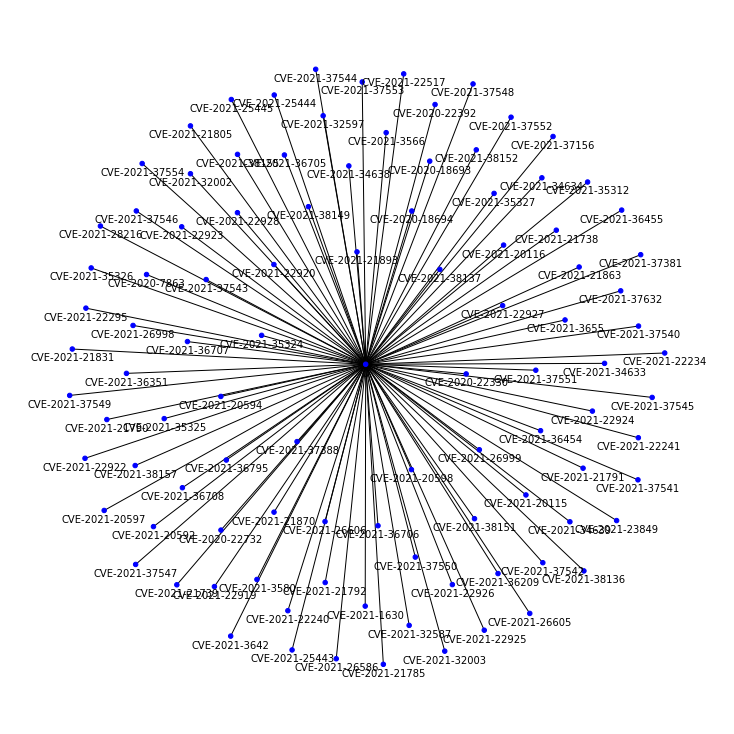

In [144]:
#Choose Range if needed / for display purposes
#cve_data = cve_data[180:250]

#Load CSV data into graph 
G = nx.from_pandas_edgelist(cve_data,'CVE', 'CWE', edge_attr=None)

#Show CVE and CWE data 
#print(G)

#dictionary mapping CVEs to different variables (date, cvss string, risk score, severity score) 
dates = pd.Series(cve_data.date.values, index=cve_data.CVE).to_dict()
vstrings =  pd.Series(cve_data.vectorString.values, index=cve_data.CVE).to_dict()
scores = pd.Series(cve_data.baseScore.values, index=cve_data.CVE).to_dict()
severities = pd.Series(cve_data.baseSeverity.values, index=cve_data.CVE).to_dict()
    

#add dictionaries to graph as node attributes
nx.set_node_attributes(G, dates, 'date')
nx.set_node_attributes(G, vstrings, 'vstring')
nx.set_node_attributes(G, scores, 'score')
nx.set_node_attributes(G, severities, 'severity')

#Verify data was added in nodes
#for i in dict(G.nodes):
#  print(dict(G.nodes).values())

#Customize  Node Sizes 
node_sizes = []
node_score = nx.get_node_attributes(G, 'score')
for key in node_score: 
    if (node_score[key] == 0.0):
        node_sizes.append(20.0) 
    if (node_score[key] != 0.0):
        node_sizes.append(node_score[key] * 10) 

count = 0 
for i in G.nodes: 
    if (G.nodes[i] == {}): 
        node_sizes.insert(count, 20.0) 
    count += 1
    
#Verify node_sizes were added in proper order 
#print(node_sizes)

#Customize Node Colors
ncolor = []
node_severity = nx.get_node_attributes(G, 'severity')
for k in node_severity:
    if node_severity[k] == 'CRITICAL':
        ncolor.append('red')
    elif node_severity[k] == 'HIGH':
        ncolor.append('pink')
    elif node_severity[k] == 'MEDIUM':
        ncolor.append('orange')
    elif node_severity[k] == 'LOW':
        ncolor.append('yellow')
    else:
        ncolor.append('blue')
        
c_count = 0 
for i in G.nodes: 
    if (G.nodes[i] == {}): 
        ncolor.insert(c_count, 'blue') 
    c_count += 1 
    
#Verify node_colors were added in proper order 
#print(node_colors)


pos_nodes=nx.spring_layout(G)

#For positioning labels
#Edit fig "-0.03" to play around with where labels should appear 
pos_attrs = {}
for node, coords in pos_nodes.items():
    pos_attrs[node] = (coords[0], coords[1] - 0.03)

#For custom Labels
keys = list(G.nodes)
values = list(G.nodes)
node_dict = dict(zip(keys, values))

#To display all saved node data (vector string, etc) on graph:
#labels = G.nodes
#Add with_labels = True in nx.draw and set desired font_size, e.g. font_size = 10
#And set labels = labels in nx.draw_networkx_labels

#Draw Graph
#Use nx.draw_networkx_labels(G, pos_nodes ,labels = node_dict, font_size = 5) if
#positions of labels directly on top of nodes desired 
graph_img = plt.figure(figsize=(10,10))
nx.draw(G, pos_nodes, node_size = node_sizes, node_color = ncolor,)
nx.draw_networkx_labels(G, pos_attrs ,labels = node_dict, font_size = 10)
plt.show()

#Save Figure as Image if needed/to share"
#graph_img.savefig('graph.png')